# matplotlib 설정

In [1]:
import matplotlib.pyplot as plt
import platform


if platform.system() == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
elif platform.system() == "Darwin":
    plt.rcParams["font.family"] = "Apple SD Gothic Neo"

plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "regular"
plt.rcParams["axes.unicode_minus"] = False

# 연도 배열 생성

In [2]:
years = [2020, 2021, 2022, 2023]

# 산점도

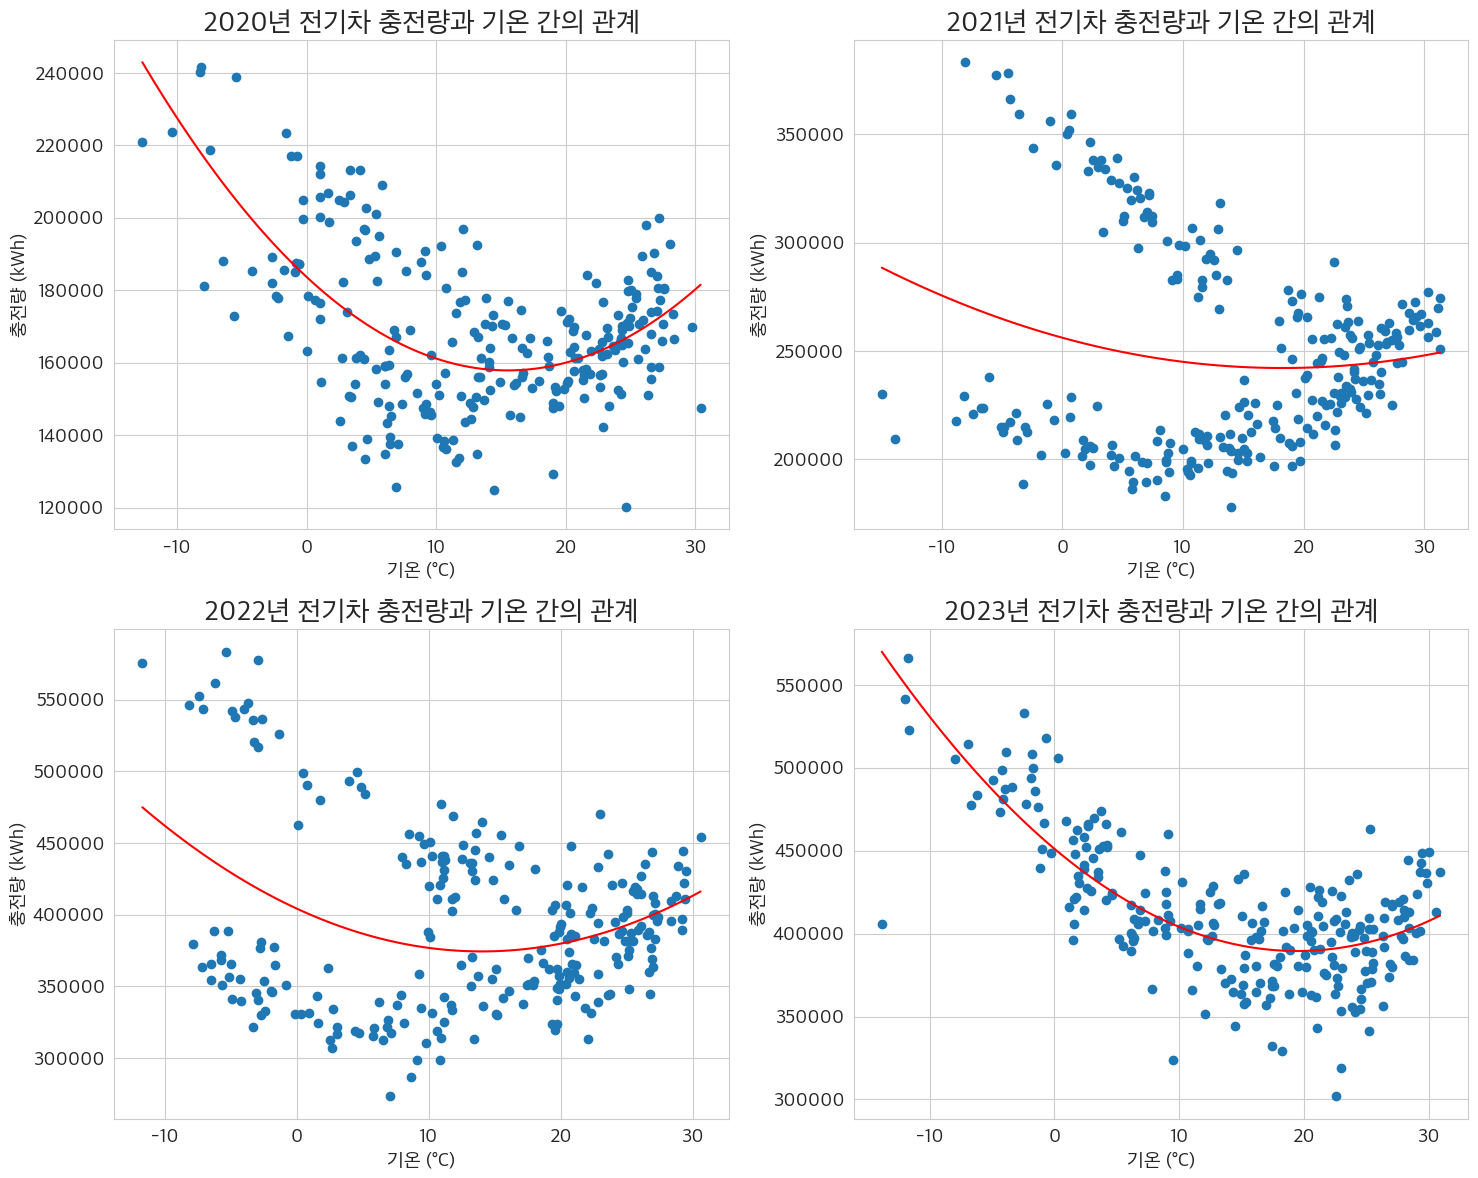

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()

for i, year in enumerate(years):
    df_temp = pd.read_csv(f"data/daily_temp_{year}.csv")
    df_ev = pd.read_csv(f"data/daily_ev_charge_{year}.csv")
    df = pd.merge(df_temp, df_ev, on="날짜")

    temp_ma = df["기온"].rolling(window=7).mean()
    charge_ma = df["충전량"].rolling(window=7).mean()

    X = df["기온"].values.reshape(-1, 1)
    y = df["충전량"].values

    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_features.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_pred_poly = poly_features.transform(X_pred)
    y_pred = model.predict(X_pred_poly)

    ax[i].scatter(df_temp["기온"].values, df_ev["충전량"].values)
    ax[i].plot(X_pred, y_pred, color="red")
    ax[i].set_xlabel("기온 (°C)")
    ax[i].set_ylabel("충전량 (kWh)")
    ax[i].set_title(f"{year}년 전기차 충전량과 기온 간의 관계", fontsize=20)

plt.tight_layout()
plt.show()

# 상자 그림

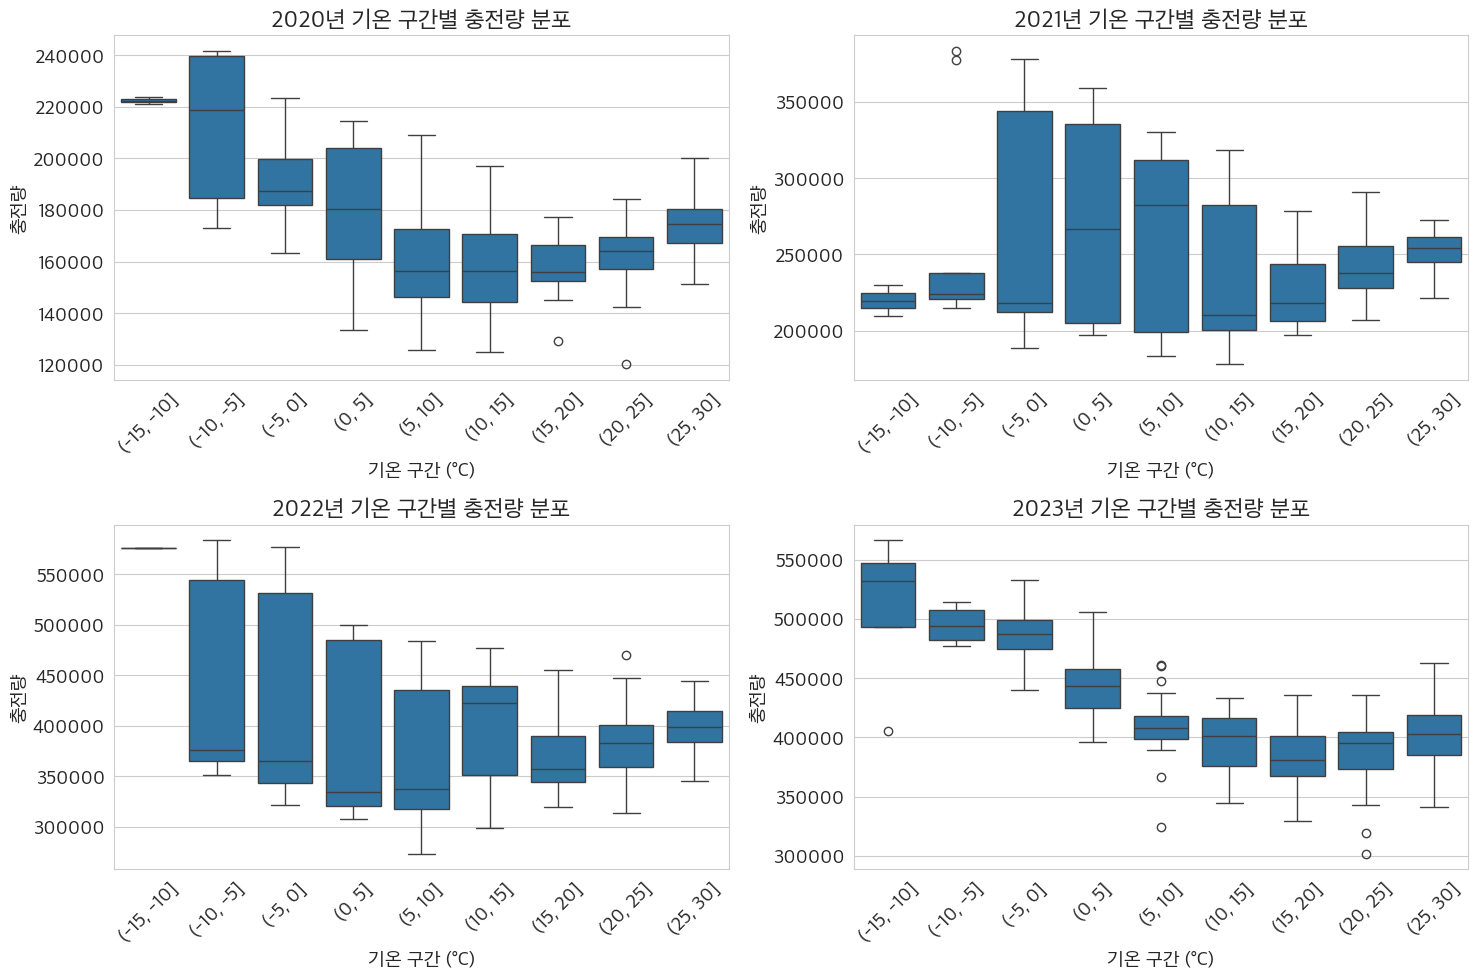

In [4]:
import seaborn as sns


def load_data(year):
    df_temp = pd.read_csv(f"data/daily_temp_{year}.csv")
    df_ev = pd.read_csv(f"data/daily_ev_charge_{year}.csv")
    df = pd.merge(df_temp, df_ev, on="날짜")
    return df


plt.figure(figsize=(15, 10))
for i, year in enumerate(years, 1):
    df = load_data(year)

    plt.subplot(2, 2, i)

    # 기온을 5도 단위로 구간화
    df["temp_bin"] = pd.cut(df["기온"], bins=range(-15, 35, 5))

    # 상자그림 그리기
    sns.boxplot(x="temp_bin", y="충전량", data=df)

    plt.title(f"{year}년 기온 구간별 충전량 분포")
    plt.xlabel("기온 구간 (°C)")
    plt.ylabel("충전량")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 연도별 시계열 그래프

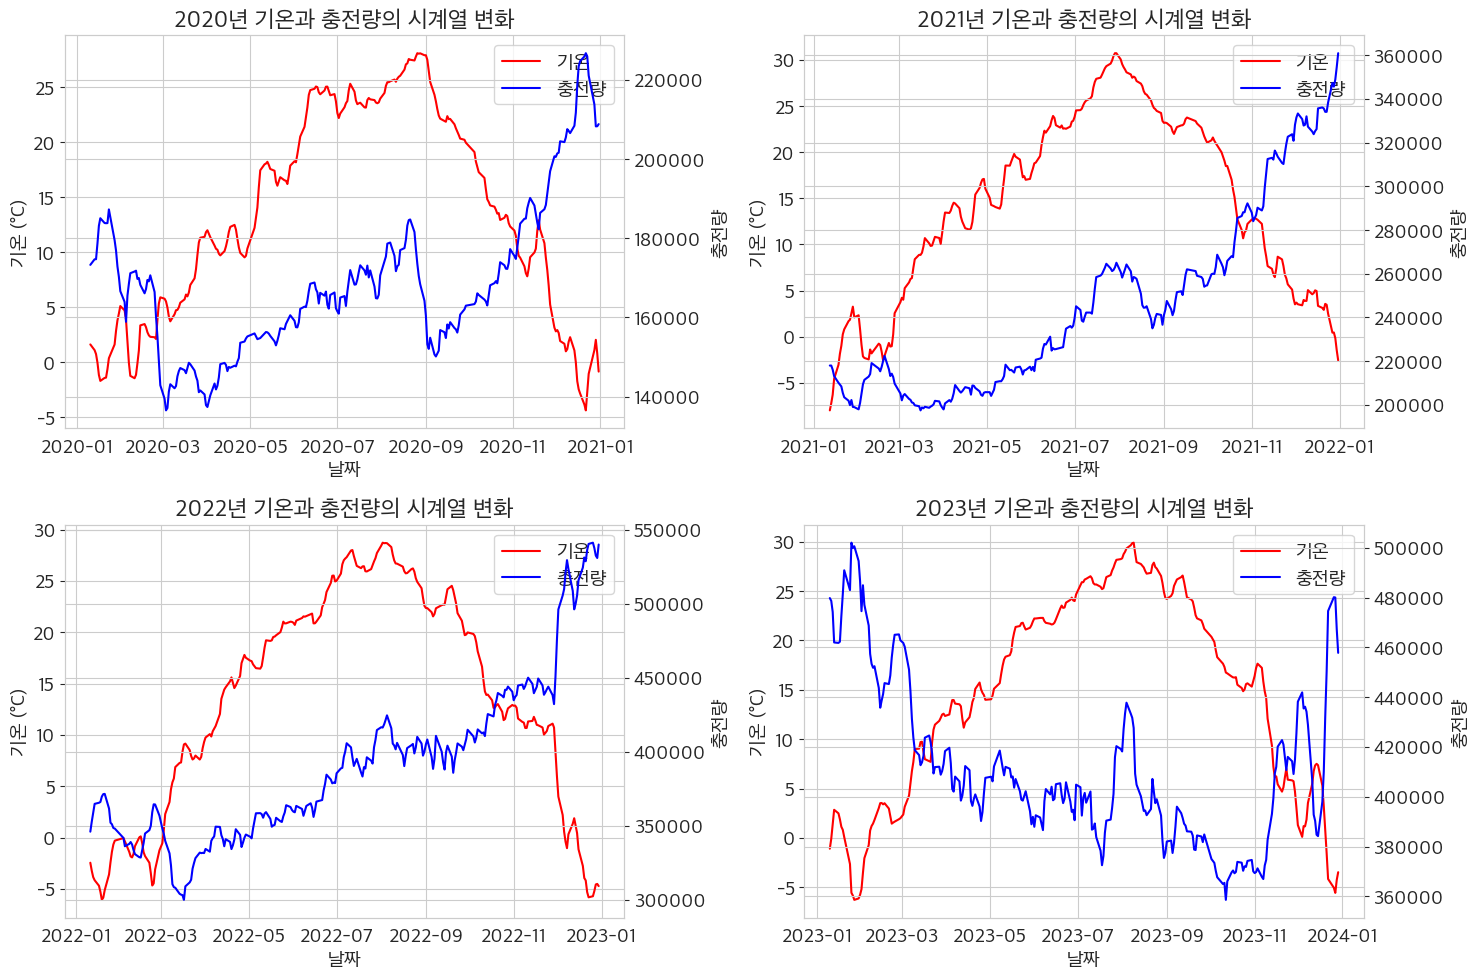

In [5]:
plt.figure(figsize=(15, 10))

for i, year in enumerate(years, 1):
    df = load_data(year)
    df["날짜"] = pd.to_datetime(df["날짜"])

    plt.subplot(2, 2, i)

    # 기온과 충전량 동시 표시
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # 7일 이동평균으로 스무딩
    temp_ma = df["기온"].rolling(window=7).mean()
    charge_ma = df["충전량"].rolling(window=7).mean()

    ax1.plot(df["날짜"], temp_ma, color="red", label="기온")
    ax2.plot(df["날짜"], charge_ma, color="blue", label="충전량")

    ax1.set_xlabel("날짜")
    ax1.set_ylabel("기온 (°C)")
    ax2.set_ylabel("충전량")

    plt.title(f"{year}년 기온과 충전량의 시계열 변화")

    # 범례 추가
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

# 트렌드 제거 시계열 그래프 & 최고기온 분석

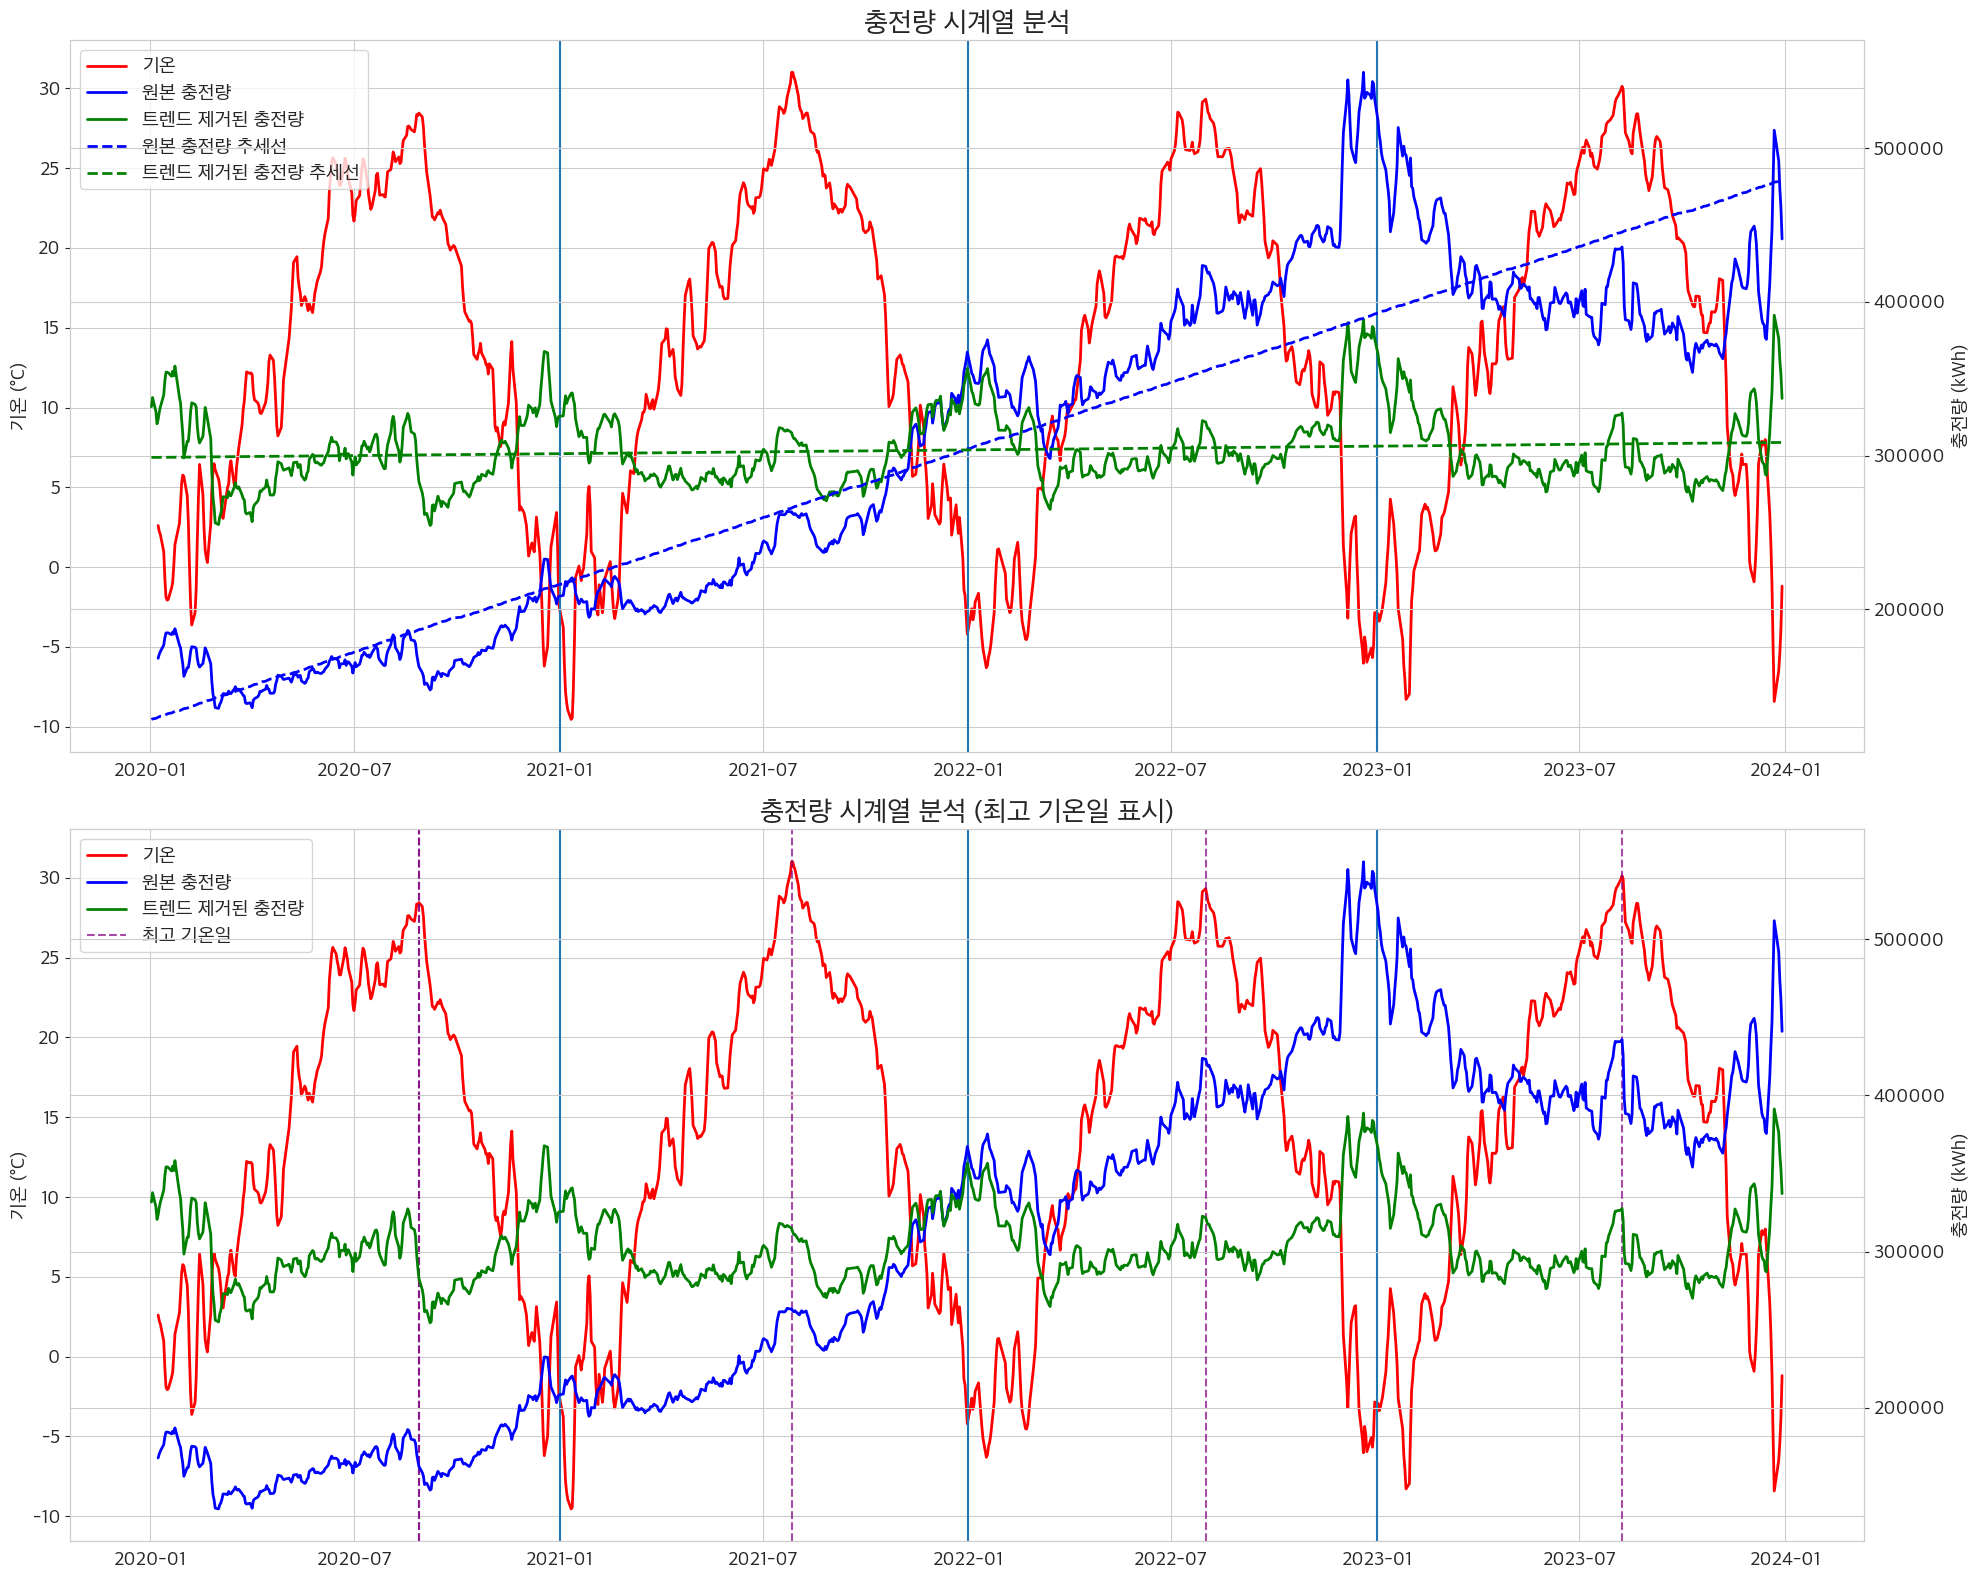

In [6]:
# 시계열 데이터 준비
combined_df = pd.DataFrame()
for year in [2020, 2021, 2022, 2023]:
    df = load_data(year)
    combined_df = pd.concat([combined_df, df])

combined_df["날짜"] = pd.to_datetime(combined_df["날짜"])
combined_df = combined_df.sort_values("날짜").reset_index(drop=True)

# 7일 이동평균 계산
combined_df["temp_ma"] = combined_df["기온"].rolling(window=5).mean()
combined_df["charge_ma"] = combined_df["충전량"].rolling(window=5).mean()

# 365일 이동평균으로 장기 트렌드 계산
trend = combined_df["충전량"].rolling(window=250, center=True, min_periods=125).mean()
detrended = combined_df["충전량"] / trend * trend.mean()
combined_df["detrended_charge_ma"] = detrended.rolling(window=5, min_periods=1).mean()

# 최고 기온 날짜 추출
peak_temp_ma_dates = []
for year in [2020, 2021, 2022, 2023]:
    mask = (
        (combined_df["날짜"].dt.year == year)
        & (combined_df["날짜"].dt.month >= 7)
        & (combined_df["날짜"].dt.month <= 9)
    )
    yearly_data = combined_df.loc[mask]
    if not yearly_data.empty:
        max_temp = yearly_data["temp_ma"].max()
        peak_date = yearly_data[yearly_data["temp_ma"] == max_temp]["날짜"].iloc[0]
        peak_temp_ma_dates.append(peak_date)

# 그래프 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16))

# 첫 번째 그래프 (최고기온 세로선 없음)
ax1_twin = ax1.twinx()

# 기온 데이터
line1 = ax1.plot(
    combined_df["날짜"],
    combined_df["temp_ma"],
    color="red",
    label="기온",
    linewidth=2,
)

# 원본 충전량과 트렌드 제거된 충전량
line2 = ax1_twin.plot(
    combined_df["날짜"],
    combined_df["charge_ma"],
    color="blue",
    label="원본 충전량",
    linewidth=2,
)
line3 = ax1_twin.plot(
    combined_df["날짜"],
    combined_df["detrended_charge_ma"],
    color="green",
    label="트렌드 제거된 충전량",
    linewidth=2,
)

# 회귀선 추가
x = np.arange(len(combined_df["날짜"]))

# 원본 충전량 회귀선
slope1, intercept1 = np.polyfit(x, combined_df["charge_ma"].fillna(0), 1)
line_charge = ax1_twin.plot(
    combined_df["날짜"],
    slope1 * x + intercept1,
    color="blue",
    linestyle="--",
    label="원본 충전량 추세선",
    linewidth=2,
)

# 트렌드 제거된 충전량 회귀선
slope2, intercept2 = np.polyfit(x, combined_df["detrended_charge_ma"].fillna(0), 1)
line_detrended = ax1_twin.plot(
    combined_df["날짜"],
    slope2 * x + intercept2,
    color="green",
    linestyle="--",
    label="트렌드 제거된 충전량 추세선",
    linewidth=2,
)

# 연도 구분선
for year in [2021, 2022, 2023]:
    ax1.axvline(pd.to_datetime(f"{year}-01-01"))

ax1.set_title("충전량 시계열 분석", fontsize=20)
ax1.set_ylabel("기온 (°C)")
ax1_twin.set_ylabel("충전량 (kWh)")

# 범례
lines1 = line1 + line2 + line3 + line_charge + line_detrended
labels1 = [l.get_label() for l in lines1]
ax1.legend(lines1, labels1, loc="upper left")

# 두 번째 그래프 (최고기온 세로선 포함)
ax2_twin = ax2.twinx()

# 기온 데이터
line4 = ax2.plot(
    combined_df["날짜"],
    combined_df["temp_ma"],
    color="red",
    label="기온",
    linewidth=2,
)

# 원본 충전량과 트렌드 제거된 충전량
line5 = ax2_twin.plot(
    combined_df["날짜"],
    combined_df["charge_ma"],
    color="blue",
    label="원본 충전량",
    linewidth=2,
)
line6 = ax2_twin.plot(
    combined_df["날짜"],
    combined_df["detrended_charge_ma"],
    color="green",
    label="트렌드 제거된 충전량",
    linewidth=2,
)

# 연도 구분선과 최고 기온일 표시
for year in [2021, 2022, 2023]:
    ax2.axvline(pd.to_datetime(f"{year}-01-01"))

for date in peak_temp_ma_dates:
    ax2.axvline(date, color="purple", linestyle="--", alpha=0.7)

if peak_temp_ma_dates:
    ax2.axvline(
        peak_temp_ma_dates[0],
        color="purple",
        linestyle="--",
        alpha=0.7,
        label="최고 기온일",
    )

ax2.set_title("충전량 시계열 분석 (최고 기온일 표시)", fontsize=20)
ax2.set_ylabel("기온 (°C)")
ax2_twin.set_ylabel("충전량 (kWh)")

# 범례
lines2 = line4 + line5 + line6 + [ax2.lines[-1]]
labels2 = [l.get_label() for l in lines2]
ax2.legend(lines2, labels2, loc="upper left")

plt.tight_layout()
plt.show()

# 트렌드 제거 산점도

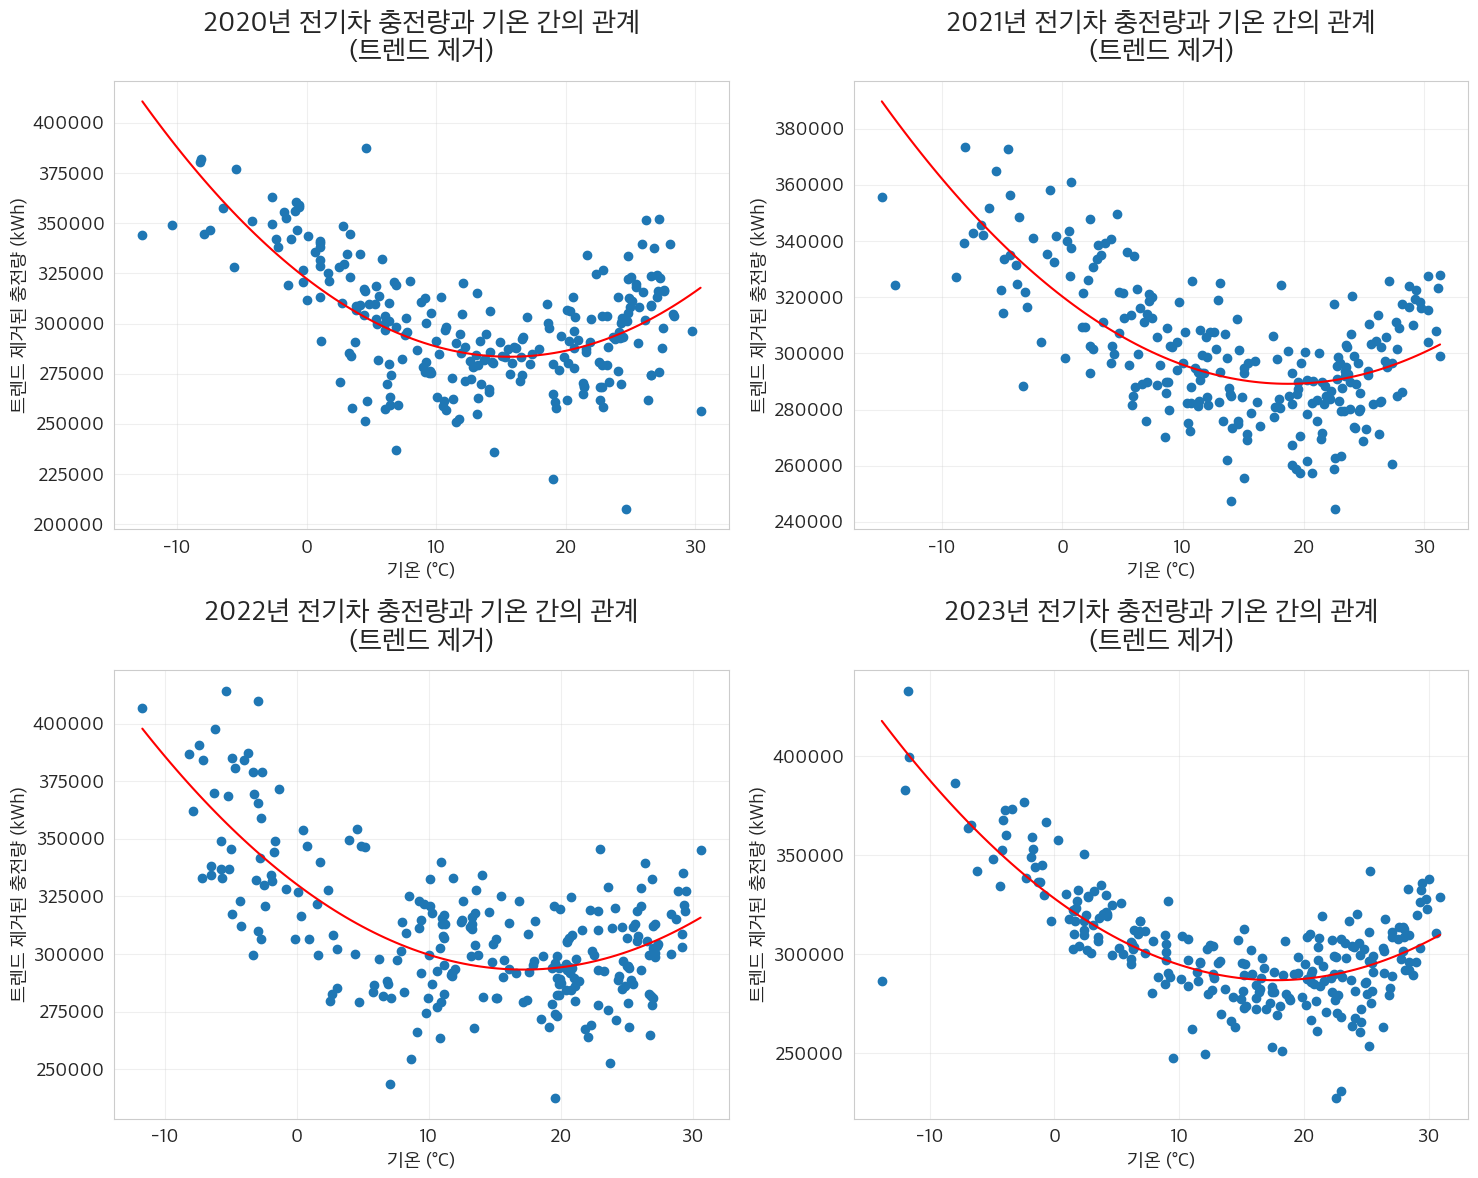

In [7]:
combined_df = pd.DataFrame()

# 모든 연도의 데이터를 먼저 합침
for year in years:
    df_temp = pd.read_csv(f"data/daily_temp_{year}.csv")
    df_ev = pd.read_csv(f"data/daily_ev_charge_{year}.csv")
    df = pd.merge(df_temp, df_ev, on="날짜")
    combined_df = pd.concat([combined_df, df])

# 날짜 컬럼을 datetime으로 변환
combined_df["날짜"] = pd.to_datetime(combined_df["날짜"])
combined_df = combined_df.sort_values("날짜").reset_index(drop=True)

# 전체 기간에 대해 트렌드 계산
overall_trend = (
    combined_df["충전량"].rolling(window=250, center=True, min_periods=125).mean()
)
detrended_charge = combined_df["충전량"] / overall_trend * overall_trend.mean()

# 그래프 생성
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()

for i, year in enumerate(years):
    # 해당 연도 데이터 추출
    mask = combined_df["날짜"].dt.year == year
    year_data = combined_df[mask].copy()
    year_detrended = detrended_charge[mask]

    # 다항 회귀 적용
    X = year_data["기온"].values.reshape(-1, 1)
    y = year_detrended.values

    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_features.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    # 예측선 생성
    X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_pred_poly = poly_features.transform(X_pred)
    y_pred = model.predict(X_pred_poly)

    # 산점도와 추세선 그리기
    ax[i].scatter(
        year_data["기온"],
        year_detrended,
        label="트렌드 제거된 데이터",
    )
    ax[i].plot(X_pred, y_pred, color="red", label="2차 다항식 추세선")

    # 그래프 꾸미기
    ax[i].set_xlabel("기온 (°C)")
    ax[i].set_ylabel("트렌드 제거된 충전량 (kWh)")
    ax[i].set_title(
        f"{year}년 전기차 충전량과 기온 간의 관계\n(트렌드 제거)", fontsize=20, pad=15
    )
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()